#Why RAG??

A trained LLM does not have knowledge of most recent information or knowledge that is available only in the proprietary documents it was not trained on. This issue is resolved by RAG or Retreival Augmented Generation

In [31]:
# Installing LangChain Dependencies
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

In [32]:
import os

# seting our environment variables to start logging traces
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = "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"

# Using LangChain's suite of integrations

Before proceeding further, we'll require 3 components from LangChain's suite of integrations namely,

**1. Chat Model** - These are language models that use a sequence of messages as inputs and return messages as outputs. Langchain provides a wide variety of them like Anthropic, Google gemini, IBM watsonx.ai, OpenAI and many more

**2. Embedding Model**-  Embeddings are used to measure the similarity between pairs of vectors and sift through extensive datasets, identifying most similar vectors. Various model providers allow you to use embeddings in LangChain (OpenAI, Google Gemini, NVIDIA, IBM Watsonx, Ollama, HuggingFace)

**3. Vector Store**- A key component of RAG is the vector database. At its core a vector database relies on ‘Embeddings’.

In [33]:
pip install -U langchain-openai


In [34]:
pip show langchain-openai

Name: langchain-openai
Version: 0.3.28
Summary: An integration package connecting OpenAI and LangChain
Home-page: 
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: langchain-core, openai, tiktoken
Required-by: 


In [35]:
# FOR ChatModel
from langchain_openai import ChatOpenAI
from google.colab import userdata
import os

# Get the OpenAI API key from Colab Secrets
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

llm = ChatOpenAI(model="gpt-4o-mini")

In [36]:
# FOR EMBEDDINGS
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()

In [37]:
# FOR VECTORSTORE
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [ ]:
# import os
# os.environ["USER_AGENT"] = "my-langchain-app/0.1"
# Place this before importing or calling any LangChain or langchain_openai modules.



In [38]:
%pip install --quiet --upgrade langchain-community

In [39]:
pip install --quiet --upgrade langgraph

In [40]:
# Importing necessary libraries
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Indexing

For our topic of interest, I’ve utilized the **WebBaseLoader**, which enables loading text content from HTML web pages into a document-friendly format. Internally, it uses urllib to fetch the HTML and '**BeautifulSoup**' to extract the text. The HTML-to-text parsing can be customized by passing arguments to the BeautifulSoup parser using the **'bs_kwargs'** parameter. **bs4.SoupStrainer** is a class within the Beautiful Soup 4 (bs4) library, a Python library used for parsing HTML and XML documents. Its primary purpose is to selectively parse portions of a document, rather than parsing the entire document. In our case, only elements with the classes **"post-content"**, **"post-title"**, or **"post-header"** are relevant—so we’ll filter out all other tags.

Next, **DocumentLoader** helps load data from a source as list of Documents.Each DocumentLoader has its own specific parameters, but they can all be invoked in the same way with the **.load** method

In [56]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43047


In [58]:
print(docs[0].page_content[:250])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, suc


The loaded document may contain more text than many models can handle within their context window. Even if a model can fit the entire post, it may still struggle to extract relevant information from such lengthy input.

To address this, we'll divide the document into smaller chunks with some overlap to maintain contextual continuity. These chunks will then be used to generate embeddings and populate a vector store, enabling us to retrieve only the most relevant sections of the blog post at runtime.

For this task, we're using **RecursiveCharacterTextSplitter**, which intelligently splits the document by recursively applying common delimiters (like new lines) until each chunk meets the desired size constraints.

In [57]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=800,  # chunk size (characters)
    chunk_overlap=150,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 82 sub-documents.


Now, it's to embed and store all of our document splits using the vector store and embeddings model we selected at the start of the tutorial i.e., Langchain's InMemoryVectorStore. Note that The base Embeddings class in LangChain provides two methods: one for
1. embedding documents
2. one for embedding a query.

The former, **.embed_documents**, takes as input multiple texts, while the latter, **.embed_query**, takes a single text. `.embed_query` will return a list of floats, whereas `.embed_documents` returns a list of lists of floats.

In [59]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:7])

['1f9a3051-afc4-45c7-8853-54d790c0ca65', '103d6737-0885-44da-9c8f-0dfb12990cb5', 'fb3cccae-daa8-45bc-8683-8a4ec6f9f6d3', '8206348f-3a71-42f3-b832-46983d9601c7', '484457af-3924-4a45-abc3-59d23ef74626', '4080004e-024c-4688-bb43-cca55c10df89', 'e050d959-eb9f-4876-8769-e633d6bb6c09']


# Retrieval & Generation
We’re implementing a workflow that takes a user’s question, retrieves documents relevant to it, feeds both the question and the retrieved content into a model as a **'PROMPT'**, and returns a generated answer.The prompt acts as the glue that combines the retriever's output with the generator's input, ensuring the model is responding based on actual content, not hallucination. Also, for generation, we will use the chat model selected earlier

In [72]:
#
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


Now, we'll use **LangGraph** to tie together the **retrieval** and **generation** steps into a single application. However, to use LangGraph, we need to define three things:

**The state of our application**(controls what data is input to the application, transferred between steps, and output by the application. It is It is typically a TypedDict. TypedDict allows you to create dictionaries with a fixed set of keys, where each key is associated with a specific type hint. This helps us define what keys are expected in the state dictionary and what type of data should be associated with each key)

**Nodes of our application**(i.e., application steps);

**Control Flow of our application** (e.g., the ordering of the steps).





In [73]:
# FOR STATE

from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [74]:
# FOR NODES (In our case, it's a simple sequence of two steps namely, retrieval and generation)
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

The retrieval step will perform a similarity search based on the input question, while the generation step will construct a prompt by combining the retrieved context with the original question for the chat model.

In [75]:
# FOR CONTROL FLOW Control flow
# Finally, we compile our application into a single 'graph' object by connecting the retrieval and generation steps into a single sequence.
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

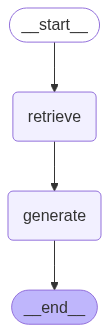

In [76]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [77]:
result = graph.invoke({"question": "What crucial role Self-Reflection plays in real-world tasks?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='e050d959-eb9f-4876-8769-e633d6bb6c09', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 3549}, page_content='Self-Reflection#\nSelf-reflection is a vital aspect that allows autonomous agents to improve iteratively by refining past action decisions and correcting previous mistakes. It plays a crucial role in real-world tasks where trial and error are inevitable.\nReAct (Yao et al. 2023) integrates reasoning and acting within LLM by extending the action space to be a combination of task-specific discrete actions and the language space. The former enables LLM to interact with the environment (e.g. use Wikipedia search API), while the latter prompting LLM to generate reasoning traces in natural language.\nThe ReAct prompt template incorporates explicit steps for LLM to think, roughly formatted as:\nThought: ...\nAction: ...\nObservation: ...\n... (Repeated many times)'), Document(id='fc061dc1-1bc9-4727-be12-7064534a9997', met

In [78]:
for message, metadata in graph.stream(
    {"question": "What crucial role Self-Reflection plays in real-world tasks??"}, stream_mode="messages"
):
    print(message.content, end="|")

|Self|-ref|lection| is| crucial| in| real|-world| tasks| as| it| allows| agents| to| iter|atively| improve| by| analyzing| past| decisions| and| correcting| errors|.| This| process| is| essential| for| navigating| trial| and| error| scenarios|,| ultimately| enhancing| future| performance|.| By| synthes|izing| experiences| and| guiding| future| actions|,| self|-ref|lection| helps| optimize| decision|-making|.||